# Timeseries forecasting

> Forecasting is the process of making predictions of the future based on past and present data.

## Basic premise

The premise which we will work under is that we have a time series, for which we want to predict its future values. We will use both statistical and Machine Learning techniques for this purpose.

When we want to give a forecast for a specific time series, we essentially need to produce $n$ predictions after the last point in time of the series; $n$ is usually referred to as the forecast **horizon**, i.e. how much into the future we want to forecast.

We want the timeseries to have the **same frequency** everywhere. The $n$ predictions will have the same frequency.

For example, if we have a monthly timeseries and a horizon of $12$, then we essentially need to make predictions for one of the next $12$ months.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We will work on the same dataset as we did in the timeseries analysis notebook.

<AxesSubplot:xlabel='Month'>

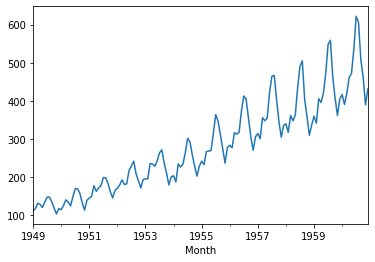

In [2]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

df = pd.read_csv(data_url)
df.index = pd.to_datetime(df['Month'])
df['Passengers'].plot()

## Temporal train-test split

To evaluate how good our forecaster is, we keep the $m$ last values in the series and use them to compare with the model's predictions for the same points in time.

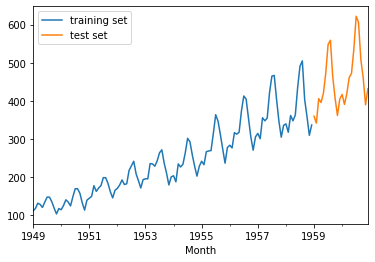

In [3]:
def temporal_train_test_split(test_start_ind):
    train_set = df[:test_start_ind]['Passengers']
    test_set = df[test_start_ind:]['Passengers']
    return train_set, test_set


test_start_ind = 120

train_set, test_set = temporal_train_test_split(test_start_ind)

train_set.plot(label='training set')
test_set.plot(label='test set')

plt.legend()

This is a monthly timeseries (i.e. one data point per month) and we will use a forecasting horizon of $12$ months.

## Naive methods

To better understand how forecasting works, we'll investigate a couple of naive methods.

### "Predict the last available data points"

This method takes the last available data point and repeats it as a prediction.

In [4]:
def convert_to_series(forecasts, ind):
    return pd.Series(forecasts, index=test_set.index[ind:ind+12])


def plot_forecasts(forecasts):
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    train_set.plot(ax=ax, label='training set')
    test_set.plot(ax=ax, label='test set')
    forecasts.plot(ax=ax, label='forecast')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('year')
    ax.set_ylabel('passengers')
    ax.legend()


def naive1(dset):
    return [dset[-1]] * 12

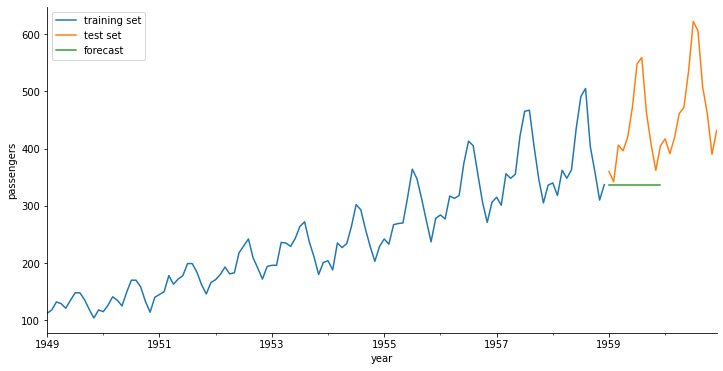

In [5]:
plot_forecasts(convert_to_series(naive1(train_set), 0))

The above forecast is the first out of many we can make for the test set. 

How would we produce the second series of forecasts? We need to shift the training set to include one more month.

In [6]:
train_set

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
Name: Passengers, Length: 120, dtype: int64

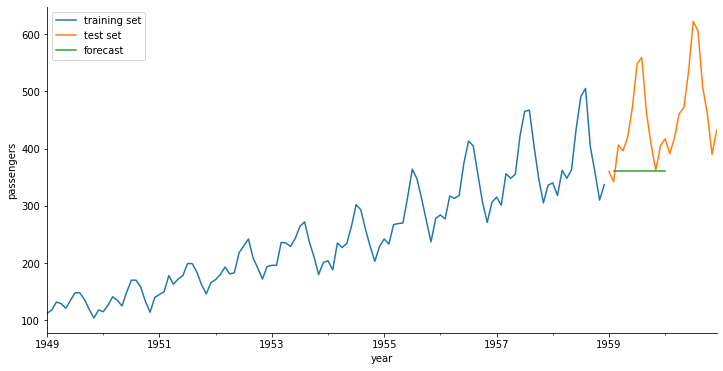

In [7]:
train_set_2, test_set_2 = temporal_train_test_split(test_start_ind+1)
plot_forecasts(convert_to_series(naive1(train_set_2), 1))

If we repeat the process for all data points in the test set we'll have all of the predictions for the test set.

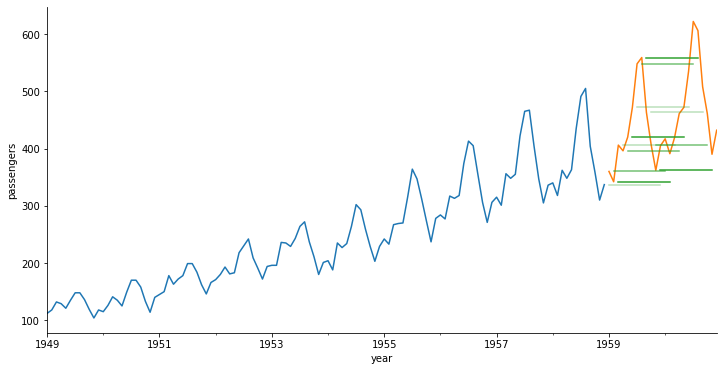

In [8]:
def plot_multiple_forecasts(preds, ax=None):
    if not ax:
        plt.figure(figsize=(12, 6))
        ax = plt.gca()

    train_set.plot(ax=ax)
    test_set.plot(ax=ax)

    for i, f in enumerate(preds):
        f.plot(ax=ax, c='C2', alpha=(i+1)/len(preds)*4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('year')
    ax.set_ylabel('passengers')
    return ax


naive1_forecasts = []

for i, ind in enumerate(range(test_start_ind, len(df)-12)):
    train, _ = temporal_train_test_split(ind)
    naive1_forecasts += [convert_to_series(naive1(train), i)]

plot_multiple_forecasts(naive1_forecasts);

Before proceeding to actually evaluating how good our model is, let's look at another naive model so that we can compare the two.

### "Predict the average of the previous k datapoints"

This technique takes the last $k$ available datapoints, computes their mean and returns that as a prediction. 

This notion of *looking back* at the $k$ most recent available datapoints is key recurring in timeseries forecasting.

In [9]:
def naive2(dset, lookback=12):
    return [dset[-lookback:].mean()] * 12

Let's get forecasts for this method, for lookback ranges of $3$, $6$, $12$ and $24$ months.

In [10]:
naive_forecasts = {'naive1': naive1_forecasts}

for lb in (3, 6, 12, 24):
    
    k = 'naive2_' + str(lb)
    naive_forecasts[k] = []

    for i, ind in enumerate(range(test_start_ind, len(df)-12)):
        train, _ = temporal_train_test_split(ind)
        naive_forecasts[k] += [convert_to_series(naive2(train, lb), i)]

Now we'll visualize the first series of forecasts for each of our forecasters.

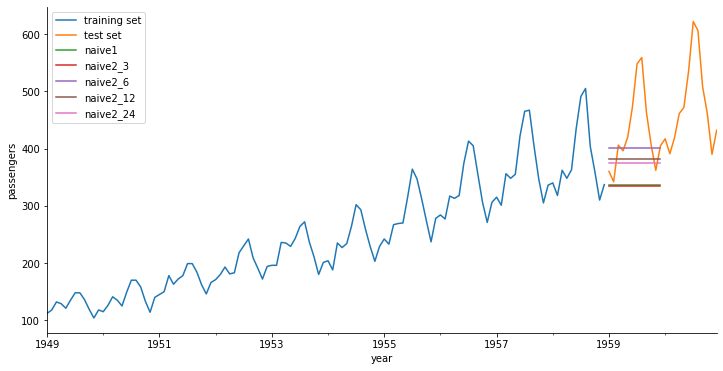

In [11]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
train_set.plot(ax=ax, label='training set')
test_set.plot(ax=ax, label='test set')

for k in naive_forecasts:
    naive_forecasts[k][0].plot(ax=ax, label=k)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('year')
ax.set_ylabel('passengers')
ax.legend()

## Evaluation

Now that we have multiple forecasts for a given horizon, we need a way to evaluate them to see which ones are best. To do this we need a **metric**. Since these are continuous values we are trying to predict we'll use a regression metric. Some popular metrics are:

- **Mean Absolute Error (MAE)**. This is useful for because it essentially shows the average error of our forecasts and is in the same unit as the variable we want to predict. 
- **Mean Squared Error (MSE)**. This error metric penalizes large mistakes more than close ones. The problem is that this isn't in the same units as our variable, making it hard to interpret. For this reason, sometimes we use its root, i.e. the **Root Mean Squared Error (RMSE)**.
- **Mean Squared Logarithmic Error (MSLE)**. This is the same as MSE, but if we first take the logarithm of the targets and predictions. This essentially measures the percentual difference of the targets with the predictions, while having the effect of not penalizing huge differences by a lot. It also has  the effect of penalizing underestimates more than overestimates. A more detailed explanation can be found [here](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-squared-logarithmic-error-(msle)). It also comes as sometimes comes as the **Root Mean Squared Logarithmic Error (RMSLE)** for the reasons discussed above.
- **Mean Absolute Percentage Error (MAPE)**. Most metrics discussed above have the effect of relying on the units of the target variable. Suppose we have train a forecaster and it returns a MAE of $5$. Is this good or bad? We cannot tell without looking at the units of the variable. If we were forecasting daily time spent commuting (in hours) it would be terrible! If we were forecasting daily visitors in the Eiffel Tower it would be great! Here is where percentage error is useful, because it measures what percentage of the target variable, do the errors correspond to.
- **Symmetric Mean Absolute Percentage Error (sMAPE)**. One issue with MAPE is that it is not symmetric (i.e. $MAPE(y, \hat y) \neq MAPE(\hat y, y)$). This is sometimes not desired. To solve this issue, sMAPE is used sometimes. This solves the aforementioned issue, but introduces another form of asymmetry: that of penalizing underestimates more than overestimates. Another thing to note on percentage errors, is that they don't work well with scaled data. 
- **Mean Absolute Scaled Error (MASE)**. MASE is different from the other errors, as it compares the forecast accuracy with the one of a one-step naive method. MASE shows essentially, how much *worse* the forecasts are from that naive method. Values under $1$ mean that the forecasts are better than the naive method.
- **r-squared ($r^2$)**. This is a popular metric used by a lot of people, however there is a lot of misconception as to what it measures. You should be [very careful](https://data.library.virginia.edu/is-r-squared-useless/) when using it!  

No metric is perfect and none gives the whole picture. Depending on our application and what we want to see, we might want to use a different one.

For our case we'll be using two of the easiest metrics to interpret, MAE and MAPE.

In [12]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Let's evaluate the first series of forecasts for the different models.

In [13]:
train, test = temporal_train_test_split(test_start_ind)

for k, v in naive_forecasts.items():
    print('{:<10}  MAE = {:.1f}  MAPE = {:.3f}'.format(k, mae(test[:12], v[0]), mape(test[:12], v[0])))

naive1      MAE = 91.3  MAPE = 19.536
naive2_3    MAE = 93.0  MAPE = 19.934
naive2_6    MAE = 51.3  MAPE = 11.035
naive2_12   MAE = 60.5  MAPE = 12.778
naive2_24   MAE = 63.6  MAPE = 13.393


The best naive method appears to be *naive2* with a lookback of 6 months. However, to know how good our model is overall, we need to compute the error **over all series of forecasts** (not just the first). 

In [14]:
def unfold_test_set(test_set):
    return np.array([test_set[i:i+12] for i in range(len(test_set)-12)])


unfolded_test_set = unfold_test_set(test_set)

for k, v in naive_forecasts.items():
    print('{:<10}  MAE = {:.1f}  MAPE = {:.1f}%'.format(k, mae(unfolded_test_set, np.array(v)), mape(unfolded_test_set, np.array(v))))

naive1      MAE = 78.0  MAPE = 16.7%
naive2_3    MAE = 75.6  MAPE = 16.2%
naive2_6    MAE = 69.0  MAPE = 14.5%
naive2_12   MAE = 61.8  MAPE = 12.3%
naive2_24   MAE = 69.5  MAPE = 13.8%


The best naive model overall is *naive2* with a window of 12 months, though these scores are not very good. A MAPE of $\approx 12\%$ means that, on average, the model is off by around $12\%$ of the value its trying to predict. This isn't ideal for such an easy task...

Let's look at its forecasts.

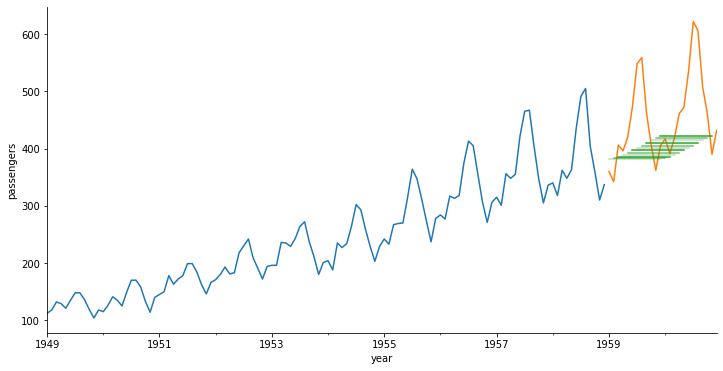

In [15]:
plot_multiple_forecasts(naive_forecasts['naive2_12']);

Interestingly enough, this model in incapable of capturing both **the trend** and the **seasonality** of the series; it is a naive model after all. 

One interesting thing we can investigate is the **bias** of this estimator, i.e. if it tends to over/under estimate systematically. 

In [16]:
def forecast_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

forecast_bias(unfolded_test_set, np.array(naive_forecasts['naive2_12']))

51.763888888888886

This model seems to systematically **underestimate** the actual values. This makes sense since the trend of the actual values are to move upwards, while the forecasts remain constant throughout the horizon.

Finally, we can visualize the predictions w.r.t the actual values. This can help give us important insights for our model's performance.

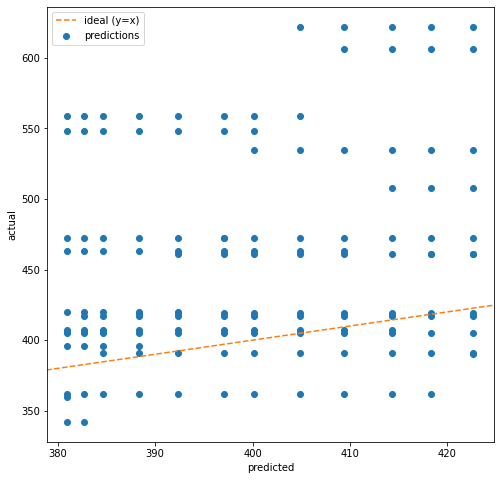

In [17]:
def plot_preds_vs_targets(y_true, y_pred):

    plt.figure(figsize=(8, 8))

    line = np.linspace(y_true.min(), y_true.max(), 10)

    ax = plt.gca()
    ax.scatter(y_pred.flatten(), y_true.flatten(), label='predictions')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.plot(line, line, c='C1', ls='--', label='ideal (y=x)')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel('predicted')
    ax.set_ylabel('actual')
    ax.legend()


plot_preds_vs_targets(unfolded_test_set, np.array(naive_forecasts['naive2_12']))

The above shows how bad our model is. The ideal predictions should be along the orange line. The farther off, the worse the predictions are. 

## Machine Learning

Since our naive methods are bad, we'll try to employ something stronger for forecasting. We'll try to train a model to predict the future passengers.

In contrast to what we've seen up till now, Machine Learning models need to be trained on the past values of the target variable, instead of other features. This is a bit tricky to pull off as ML models we know try to learn the mapping $X \rightarrow y$ and not $y_{t-i} \rightarrow y_t$, which we want.


To be able to use scikit-learn models for forecasting we'll need to **transform** our dataset to a more appropriate form. We'll need to make features out of the previous points in time of our series. This procedure is sometimes referred to as [reduction](https://www.sktime.org/en/latest/examples/01_forecasting.html#Key-idea:-Reduction), as we are *reducing* the forecasting task, into the simpler task of tabular regression.

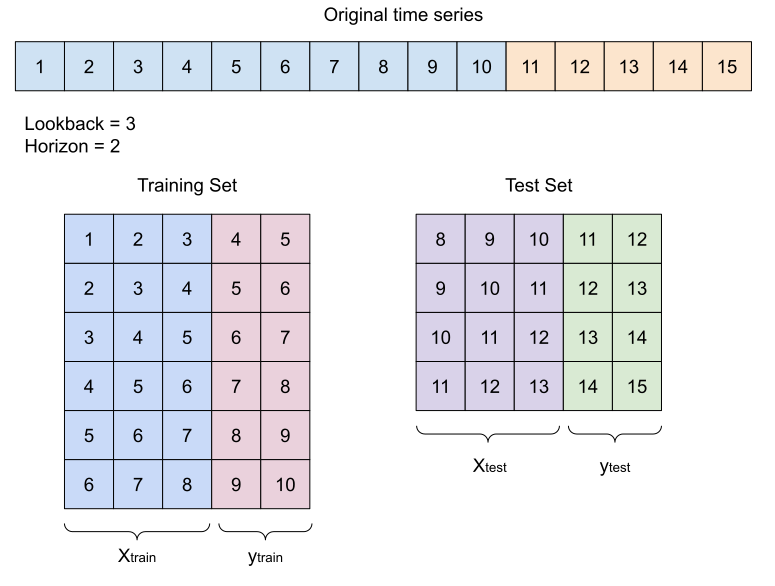

We'll need to decide how many timesteps into the past to *look back*. First we'll use a lookback window of $24$ months. 

In [18]:
def build_dset(dset, lookback, horizon):
    data = pd.concat([dset.shift(-i) for i in range(lookback+horizon)], axis=1).dropna()
    data.columns = range(-lookback, horizon)
    data.index = dset.index[-len(data):]
    return data.iloc[:, :lookback], data.iloc[:, lookback:]

x, y = build_dset(df['Passengers'], 24, 12)

In [19]:
x.head(1)

,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
Month,,,,,,,,,,,,,,,,,,,,,,,,
1951-12-01,112,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,170.0,170.0,158.0,133.0,114.0,140.0


In [20]:
y.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11
Month,,,,,,,,,,,,
1951-12-01,145.0,150.0,178.0,163.0,172.0,178.0,199.0,199.0,184.0,162.0,146.0,166.0


Take a look at the first sample in our dataset. This is the sample for January 1951. The first 24 columns in `x` store the monthly passengers for the previous 24 months. This is our **lookback**! 

The 12 columns in `y` represent the Passengers for Jan. 1951 and its next 11 months. These are the values we want our model to forecast, i.e. our **horizon**.

The 24 columns in `x` are the Passengers for the 24 months before Jan 1951.

<AxesSubplot:>

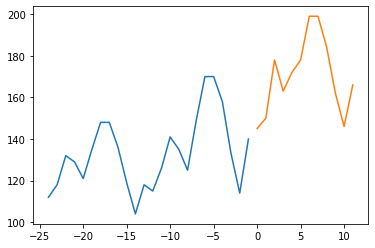

In [21]:
x.iloc[0].plot()
y.iloc[0].plot()

The next sample will store the lookback and horizon for another month in the dataset. 

Before we can train a model on this dataset, we need to perform a temporal train-test split first.

In [22]:
train_end_date = '1959-01-01'
test_start_date = '1960-01-01'

x_train = x[:train_end_date]
x_test = x[test_start_date:]

y_train = y[:train_end_date]
y_test = y[test_start_date:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((86, 24), (12, 24), (86, 12), (12, 12))

We ended the train set 12 months (i.e. length of horizon) prior to the test set to avoid data leakage. If we didn't do this the first months of the test set would have been seen in the horizon of the last months of the training set.

First we'll try to train a linear regression model on this dataset.

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train, y_train)

preds = lr.predict(x_test)

Let's visualize the first series of forecasts. Feel free to play with `i` to how well the model predicts for its other predictions.

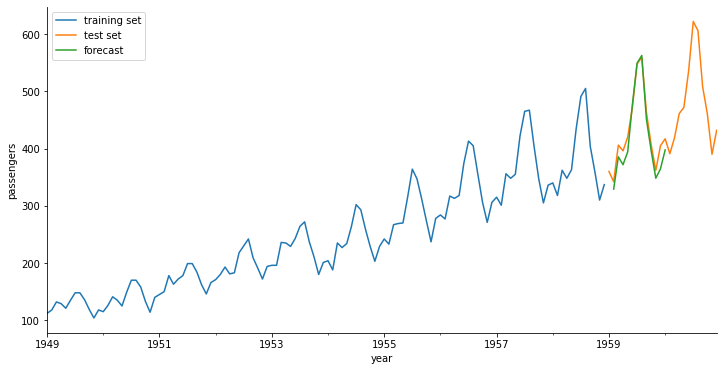

In [24]:
def convert_to_series_2(predictions, ind):
    df_ind = np.where(df.index == test_start_date)[0][0] + ind
    return pd.Series(predictions, index=df.index[df_ind-11:df_ind+1])
    
    
i = 0

plot_forecasts(convert_to_series_2(preds[i], i))

The model seems a lot stronger than the others. Let's see how well it performs.

First of all let's plot all of its predictions.

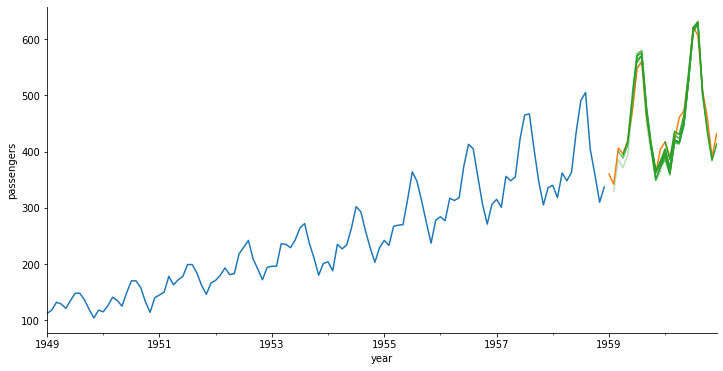

In [25]:
plot_multiple_forecasts([convert_to_series_2(f, i) for i, f in enumerate(preds)]);

In [26]:
print('Linear Regression (lookback=24)  MAE = {:.1f}  MAPE = {:.1f}%'.format(mae(y_test.values, preds), mape(y_test.values, preds)))

Linear Regression (lookback=24)  MAE = 16.2  MAPE = 3.6%


Our model performs a lot better than the previous.

In [27]:
forecast_bias(y_test.values, preds)

7.714972562379602

There is still a bit of under-forecasting happening (probably because of the large trend).  Finally, let's see a scatterplot of our predictions vs the actual values.

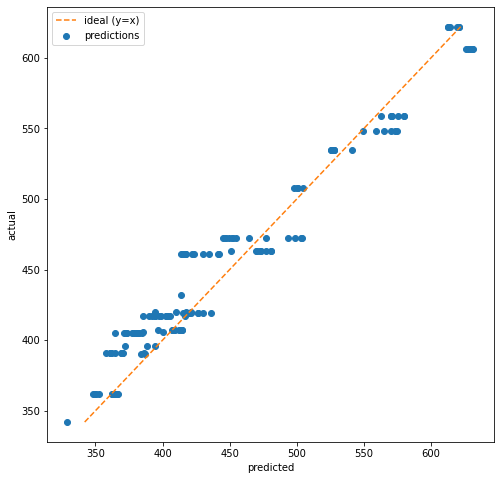

In [28]:
plot_preds_vs_targets(y_test.values, preds)

Here the forecasts are **much closer** to the $y=x$ line than before. This plot makes it easy for us to visually evaluate our model. For instance, the under-forecasting becomes apparent here. Everything above the dotted line means that the actual value was higher than the forecasted; an error that our model does systematically. 

### Feedback

Another interesting concept, we'll introduce, is that of obtaining forecasts for an arbitrary horizon by feeding the predictions back to the model. The idea is instead of asking a model to predict 12 values into the future, to **ask it to just produce 1**. Then feed this predicted value as an observation and repeat the process 11 more times. Let's see how this would play out. 

First, we'll create a dataset with a forecast horizon of $1$.

In [29]:
x, y = build_dset(df['Passengers'], 24, 1)  # again a lookback of 24, but now a horizon of 1

In [30]:
x.head(1)

,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
Month,,,,,,,,,,,,,,,,,,,,,,,,
1951-01-01,112,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,170.0,170.0,158.0,133.0,114.0,140.0


In [31]:
y.head(1)

,0
Month,
1951-01-01,145.0


In [32]:
train_end_date = '1958-12-01'  # here, due to the lack of a horizon we don't need to worry about leakage
test_start_date = '1959-01-01'

x_train2 = x[:train_end_date]
x_test2 = x[test_start_date:]

y_train2 = y[:train_end_date]
y_test2 = y[test_start_date:]

x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape

((96, 24), (24, 24), (96, 1), (24, 1))

Now, we'll train a simple linear regression on this dataset.

In [33]:
lr = LinearRegression()

lr.fit(x_train2, y_train2)

LinearRegression()

The predictions are a bit trickier to get, as we'll need to get one prediction as a time and pass that as a datapoint. We'll do this $12$ times to get the first series of forecasts.

In [34]:
def predict_n_ahead(model, x, n=12):
    
    preds = []
    x_tmp = x.copy()

    for i in range(n):
        p = model.predict(x_tmp.reshape(1, -1))[0][0]
        x_tmp = np.r_[x_tmp[1:], p]
        preds.append(p)

    return np.array(preds)

Let's see how it performs.

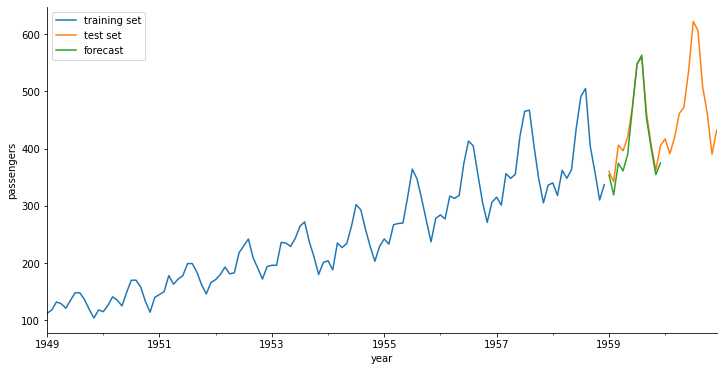

In [35]:
i = 0

preds = predict_n_ahead(lr, x_test2.values[i])

plot_forecasts(convert_to_series_2(preds, i+11))  # this function was built with the assumption that there was a 12-month gap between training and test set

Let's get predictions for the whole dataset.

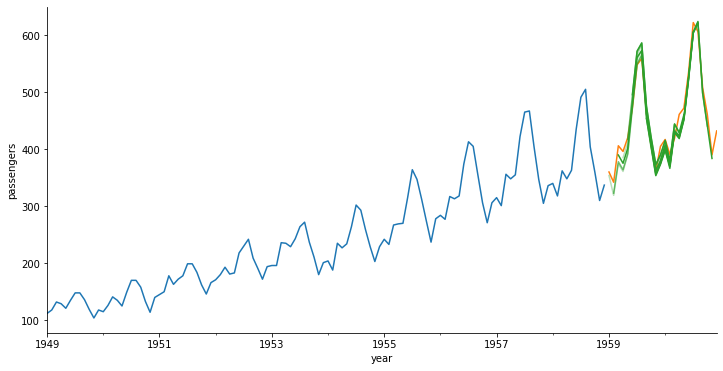

In [36]:
preds = np.array([predict_n_ahead(lr, x) for x in x_test2.values[:-12]])
plot_multiple_forecasts([convert_to_series_2(f, i+11) for i, f in enumerate(preds)]);

Linear Regression (lookback=24)  MAE = 15.7  MAPE = 3.5%
Bias: 6.5


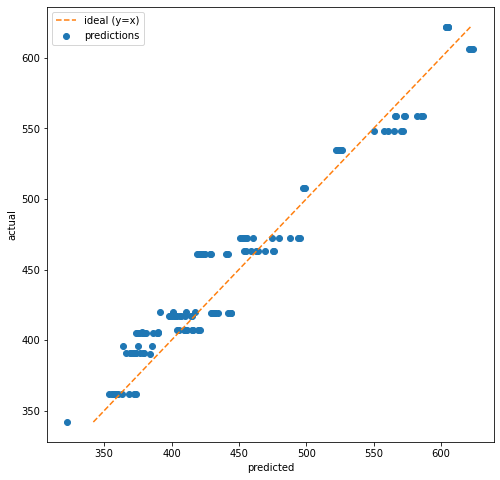

In [37]:
# TODO: for some reason y_test and preds are unaligned by 1 month. 
# Need to fix this!!!

print('Linear Regression (lookback=24)  MAE = {:.1f}  MAPE = {:.1f}%'.format(mae(y_test.values[:-1], preds[1:]), mape(y_test.values[:-1], preds[1:])))

print('Bias: {:.1f}'.format(forecast_bias(y_test.values[:-1], preds[1:])))

plot_preds_vs_targets(y_test.values[:-1], preds[1:])

With the same procedure, we can incorporate **any** scikit-learn regressor for forecasting. 

### What if we had more features?

Up till now, we've seen how to predict $y_t$ from $y_{t-i}, i \in [1, ..., T]$, but what if we had $j$ more timeseries, $X_{j, t}$? Assuming that $X$ has some correlation with $y$, we could use $y_{t-i}$ along with any number of the features $X_{j, t-i}$. The idea is that $X$ might give us some information, unavailable just from $y$ and improve our forecasts.

Our final dataset would look something like this:


Some things to note:

- If $y$ preceds $x$, then $x$ **cannot** be used to predict $y$. It makes sense if you think about it... *we cannot predict lightning by knowing when thunder struck*.
- There might be a **lag** between a feature $x_t = X_{j, t}$ and $y_t$, meaning that the effect of $x_t$ might appear after some time. It would be helpful if we took that into account, by shifting $x$ accordingly. *A drop in the temperature in a neighboring country might indicate that a storm is coming, however it will take some time to come.*

## A simpler way...

Even though we can theoretically use any scikit-learn regressor for forecasting, this requires a lot of tweaking and this is prone to errors. Instead we could use a library tailor made for forecasting, which can make our life easier: [sktime](https://www.sktime.org/).

To install this you might want to run:

```
!pip install sktime[all_extras]
```

sktime comes with a lot of built-in functionality, that will replace some of our own custom functions.

120 24


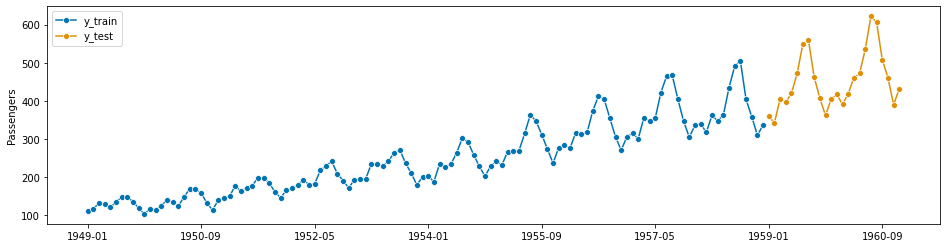

In [38]:
from sktime.forecasting.all import temporal_train_test_split, plot_series

 # sktime for some reason doens't work with 'MS' frequency. 
 # Instead it wants a PeriodIndex to work properly...
y = df['Passengers'].to_period('M') 

y_train, y_test = temporal_train_test_split(y, test_size=24)  # keep the last 24 months test set

plot_series(y_train, y_test, labels=['y_train', 'y_test'])

print(y_train.shape[0], y_test.shape[0])

Unfortunately, at this time [`plot_series`](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.utils.plotting.plot_series.html) offers **minimal options for customization** and in some cases we might be better off to just draw them on our own)!

Let's build a naive forecaster (similar to the *naive2* we crated on our own) with sktime.

sMAPE: 0.1406845354903771


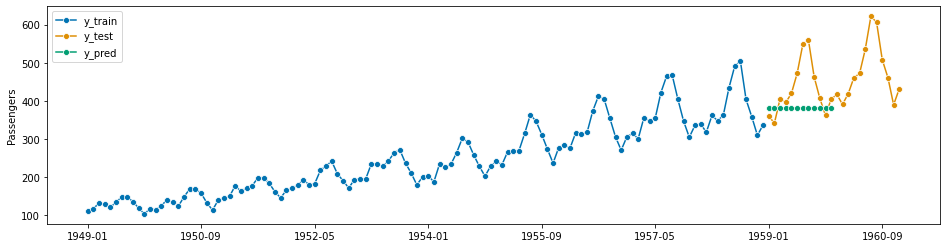

In [39]:
from sktime.forecasting.all import ForecastingHorizon, NaiveForecaster, smape_loss

fh = ForecastingHorizon(y_test.index[:12], is_relative=False)  # define a forecast horizon of 12-steps ahead

forecaster = NaiveForecaster(strategy='mean', window_length=12)  # mean prediction of the past 12 values
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print('sMAPE:', smape_loss(y_test[:12], y_pred))

### Dynamic forecasting

Obviously, this is the **first** of the series of forecasts. To get the complete series of forecasts we need to do two things:

1. define the strategy with which we are going to split the test set into  windows (in our case we want **overlapping 12-month windows**)
2. update our model with the latest data as the time progresses (e.g. for our model to predict the passengers for the window Jan-Dec 1960, the model needs to average the values for 1959, which is in the test set)

We can do this as follows.

In [40]:
from sktime.forecasting.all import SlidingWindowSplitter

# First, we need to define the strategy with which to "split" the test set.
# In this case we need to use sliding windows with a length of 12 months  
cv = SlidingWindowSplitter(fh=np.arange(1, 13))  

# To make dynamic forecasts, we need to call 'update_predict'  
# on the new test set with the defined splitting strategy
y_pred = forecaster.update_predict(y_test, cv)

sktime uses a really convenient format for storing its windows.

In [41]:
y_pred.head(20)

,1958-12,1959-01,1959-02,1959-03,1959-04,1959-05,1959-06,1959-07,1959-08,1959-09,1959-10,1959-11,1959-12
1959-01,381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02,381.0,382.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03,381.0,382.666667,384.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04,381.0,382.666667,384.666667,388.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-05,381.0,382.666667,384.666667,388.333333,392.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-06,381.0,382.666667,384.666667,388.333333,392.333333,397.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-07,381.0,382.666667,384.666667,388.333333,392.333333,397.083333,400.166667,NaN,NaN,NaN,NaN,NaN,NaN
1959-08,381.0,382.666667,384.666667,388.333333,392.333333,397.083333,400.166667,404.916667,NaN,NaN,NaN,NaN,NaN
1959-09,381.0,382.666667,384.666667,388.333333,392.333333,397.083333,400.166667,404.916667,409.416667,NaN,NaN,NaN,NaN
1959-10,381.0,382.666667,384.666667,388.333333,392.333333,397.083333,400.166667,404.916667,409.416667,414.333333,NaN,NaN,NaN


Note how the first column, represents the predictions for Dec 1958, which start from Jan 1959 to Dec 1959. The rest of the values are `NaN`. If we want to access the N-th series of forecasts we just need to extract the N-th column and drop all `NaN` values.

1959-05    392.333333
1959-06    392.333333
1959-07    392.333333
1959-08    392.333333
1959-09    392.333333
1959-10    392.333333
1959-11    392.333333
1959-12    392.333333
1960-01    392.333333
1960-02    392.333333
1960-03    392.333333
1960-04    392.333333
Freq: M, Name: 1959-04, dtype: float64

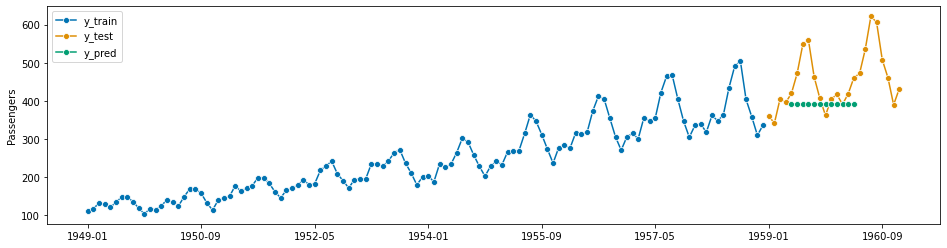

In [42]:
n = 4  # N-th series of predictions

plot_series(y_train, y_test, y_pred.iloc[:, n], labels=['y_train', 'y_test', 'y_pred'])

y_pred.iloc[:, n].dropna()

By looking at the documentation of `plot_series()`, we can plot an arbitrary number of timeseries, which is helpful in this case.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Passengers'>)

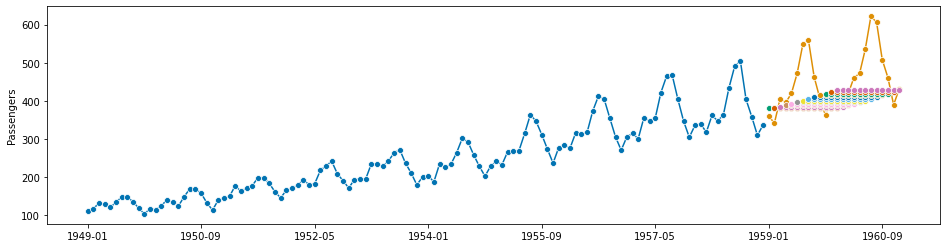

In [43]:
plot_series(y_train, y_test, *[pred[1] for pred in y_pred.T.iterrows()])

### Stronger models

Let's try to use a stronger statistical model, referred to as [simple exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) strategy. This is one of many exponential smoothing techniques that use a moving average, but pays more attention to more recent datapoints.

sMAPE: 0.2262927725785674


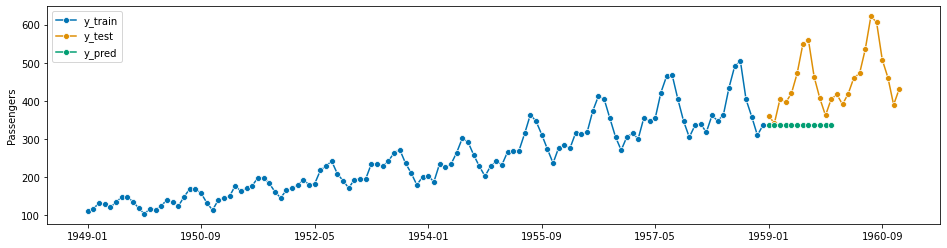

In [44]:
from sktime.forecasting.all import ExponentialSmoothing

fh = ForecastingHorizon(y_test.index[:12], is_relative=False)  # define a forecast horizon of 12-steps ahead

forecaster = ExponentialSmoothing(sp=12)  # use a 12-month window
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print('sMAPE:', smape_loss(y_test[:12], y_pred))

sktime models also offer a lot of ways to improve performance, via **decomposition**, [damping](https://otexts.com/fpp2/holt.html#example-air-passengers-continued), [box-cox transformations](https://www.statisticshowto.com/box-cox-transformation) and more.

sMAPE: 0.04938238380509715


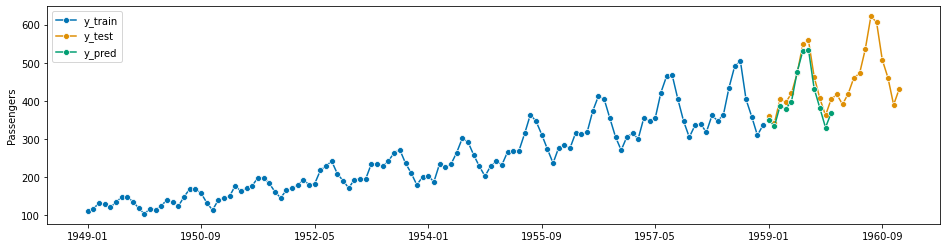

In [45]:
# Decomposition assuming additive trend and multiplicative seasonality
forecaster = ExponentialSmoothing(trend='add', seasonal='mul', sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print('sMAPE:', smape_loss(y_test[:12], y_pred))

### Uncertainty

Up till now we've only seen point forecasts. In some cases we might be also interested in the **uncertainty** of the forecasts. One way to estimate this is through **confidence intervals**. At the time of writing this notebook, sktime claims to support this functionality for only a limited number of models. 

sMAPE: 0.10795041941243716


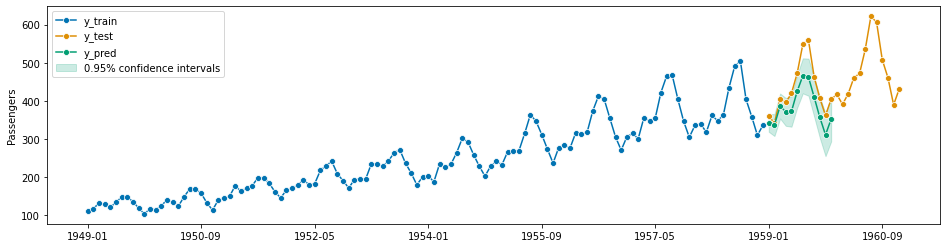

In [46]:
# At the time of writing this sktime does not support prediction intervals 
# for ExponentialSmoothing, so we'll use the ThetaForecaster

from sktime.forecasting.all import ThetaForecaster

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)

alpha = 0.05  # 95% confidence intervals

y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

_, ax = plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
ax.fill_between(ax.get_lines()[-1].get_xdata(),
                pred_ints['lower'],
                pred_ints['upper'],
                alpha=0.2,
                color=ax.get_lines()[-1].get_c(),
                label=f'{1 - alpha}% confidence intervals')
ax.legend()

print('sMAPE:', smape_loss(y_test[:12], y_pred))

**Disclaimer**: This notebook is not intended to be a tutorial for sktime, just to showcase one of the many available options out there for forecasting. For more detailed documentation and tutorials refer to the library's [official documentation](https://www.sktime.org/en/latest/user_guide.html).

## Exercise: Predict the progression of COVID-19

We'll now try to apply some of the methods we saw for predicting how COVID-19 new cases will progress in Greece.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='new_cases'>)

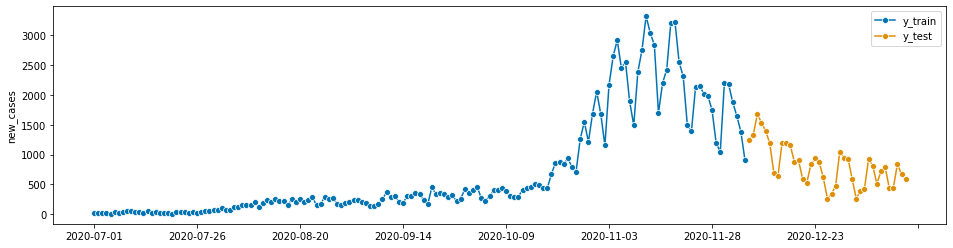

In [72]:
covid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
covid.index = pd.to_datetime(covid['date'])

y = covid.loc[covid['location'] == 'Greece', 'new_cases'].to_period('D')
y = y['2020-07-01':]  # use data from July

y_train, y_test = temporal_train_test_split(y, test_size=40)  # 30 days test set

plot_series(y_train, y_test, labels=['y_train', 'y_test'])

Let's try to forecast the progression.

sMAPE: 0.4766161426320724


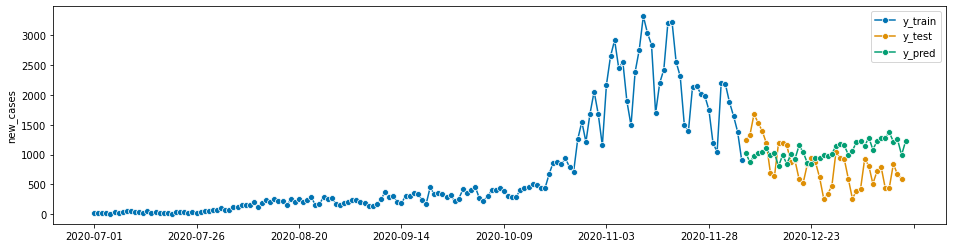

In [73]:
forecaster = ThetaForecaster(sp=30)  # use a theta model with a 30-day lookback window

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)  # predict the whole test set
                                                          # (i.e. 30-days ahead)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print('sMAPE:', smape_loss(y_test, y_pred))

We only need to look at the predictions to tell that our model isn't doing very well. Of course forecasting 30-steps ahead isn't very easy, but the model isn't even performing well on the next days. 

One possibility is the noisiness in the data. Let's try to apply an exponential smoothing model and play with the parameters to see how they affect the forecasts.

                          None  sMAPE: 0.372
                   trend='add'  sMAPE: 0.420
                   trend='mul'  sMAPE: 0.632
                seasonal='add'  sMAPE: 0.395
                seasonal='mul'  sMAPE: 0.996


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


   trend='add', seasonal='add'  sMAPE: 0.556
   trend='add', seasonal='mul'  sMAPE: 0.641


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


   trend='mul', seasonal='mul'  sMAPE: 0.388


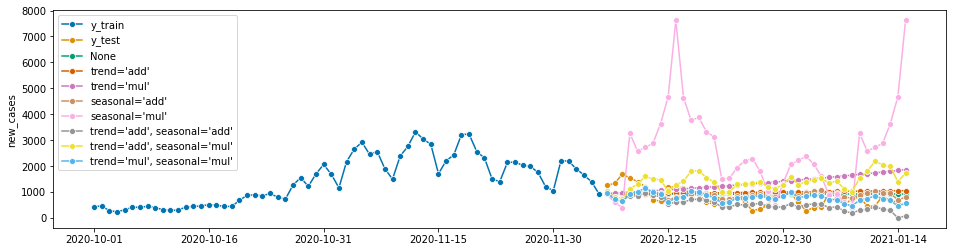

In [74]:
def train_plot_multiple(models, names):

    preds = []

    for m, n in zip(models, names):

        m.fit(y_train)

        preds.append(m.predict(fh))

        print('{:>30}  sMAPE: {:.3f}'.format(n, smape_loss(y_test, preds[-1])))

    return plot_series(y_train['2020-10-01':], y_test, *preds, labels=['y_train', 'y_test', *names])


models = [ExponentialSmoothing(sp=30),
          ExponentialSmoothing(trend='add', sp=30),
          ExponentialSmoothing(trend='mul', sp=30),
          ExponentialSmoothing(seasonal='add', sp=30),
          ExponentialSmoothing(seasonal='mul', sp=30),
          ExponentialSmoothing(trend='add', seasonal='add', sp=30),
          ExponentialSmoothing(trend='add', seasonal='mul', sp=30),
          ExponentialSmoothing(trend='mul', seasonal='mul', sp=30)]

names = ['None', "trend='add'", "trend='mul'", "seasonal='add'",
         "seasonal='mul'", "trend='add', seasonal='add'",
         "trend='add', seasonal='mul'", "trend='mul', seasonal='mul'"]

train_plot_multiple(models, names);

The "gray" line seems to be the closes one to the test set.

                   lookback=10  sMAPE: 0.425
                   lookback=20  sMAPE: 0.399
                   lookback=30  sMAPE: 0.556
                   lookback=40  sMAPE: 1.565
                   lookback=50  sMAPE: 1.419
                   lookback=60  sMAPE: 1.784
                   lookback=70  sMAPE: 1.709


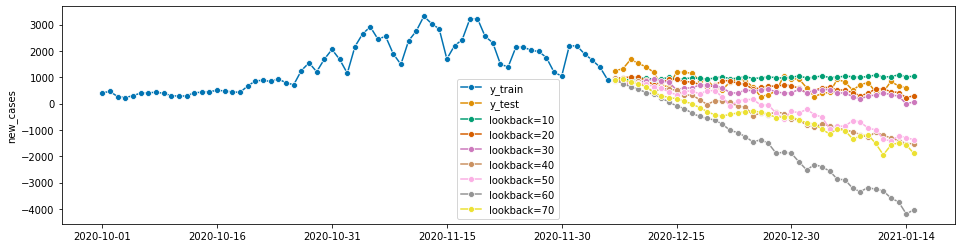

In [75]:
models = [ExponentialSmoothing(trend='add', seasonal='add', sp=i) for i in range(10, 71, 10)]
names = ['lookback={}'.format(i) for i in range(10, 71, 10)]

train_plot_multiple(models, names);

The best model here seems to be the "gray" one again.

**Important note**: a better way to do hyperparameter tuning would be to perform a [grid search](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.ForecastingGridSearchCV.html#sktime.forecasting.model_selection.ForecastingGridSearchCV), however our goal here was to see how the parameters affect the model.

sMAPE: 0.5562708760103633


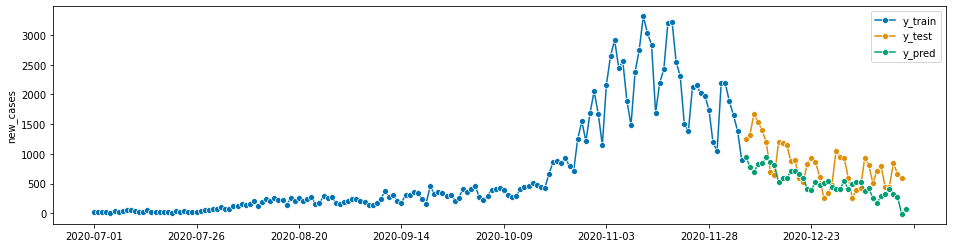

In [77]:
best_es = models[2]  # best model
y_pred = best_es.predict(fh)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print('sMAPE:', smape_loss(y_test, y_pred))

Let's see if we can improve the model's performance by reducing the noise.

Original sMAPE: 0.5562708760103633
Smooth sMAPE:   0.9843119727916007


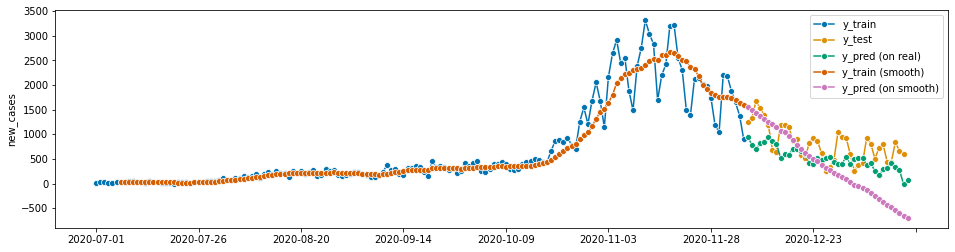

In [78]:
y_smooth = y_train.rolling(7).mean().dropna()

best_es.fit(y_smooth)

y_pred_on_smooth = best_es.predict(fh)

plot_series(y_train, y_test, y_pred, y_smooth, y_pred_on_smooth,
            labels=['y_train', 'y_test', 'y_pred (on real)',
                    'y_train (smooth)', 'y_pred (on smooth)'])

print('Original sMAPE:', smape_loss(y_test, y_pred))
print('Smooth sMAPE:  ', smape_loss(y_test, y_pred_on_smooth))

Finally, we'll try to play around with decomposing the timeseries and trying to predict each component on its own. Theoretically, since we are using weaker models, this should help them out.

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose does not work with a PeriodIndex. 
# The following is a workaround to bring back the freq...
def convert_to_dt(series):
    per_series = series.copy()
    per_series.index = per_series.index.to_timestamp()
    return per_series

y_train_freq = convert_to_dt(y_train)
dec = seasonal_decompose(y_train_freq, model='multiplicative')

y_trend = dec.trend.dropna().to_period('D')
y_season = dec.seasonal.dropna().to_period('D')

First, let's make a model that predicts the trend of the series.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='new_cases'>)

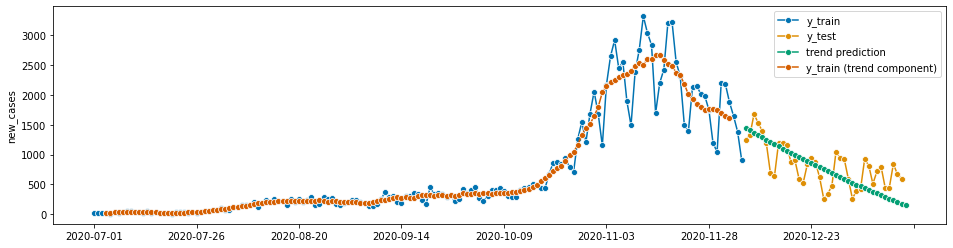

In [82]:
es_trend = ExponentialSmoothing(trend='add', sp=30, damped_trend=True)
es_trend.fit(y_trend)
y_trend_pred = es_trend.predict(fh)

plot_series(y_train, y_test, y_trend_pred, y_trend, 
            labels=['y_train', 'y_test', 'trend prediction', 'y_train (trend component)'])

The trend is adequately captured during the first days of the horizon, but not well enough during the latter days. One possible solution could to *damp* the trend. However, we'll stick with this model for now. 

Let's, we'll make a model that predicts the seasonality.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='seasonal'>)

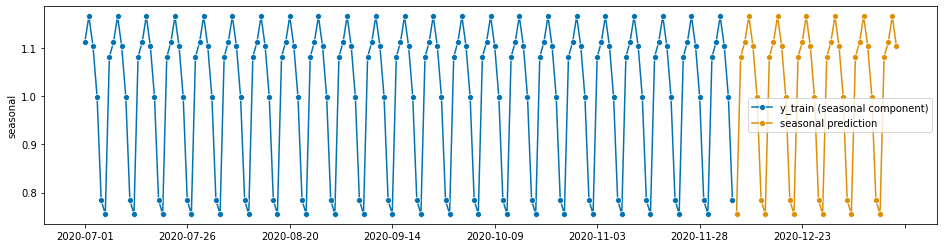

In [83]:
es_season = ExponentialSmoothing(seasonal='add', sp=7)
es_season.fit(y_season)
y_season_pred = es_season.predict(fh)

plot_series(y_season, y_season_pred, labels=['y_train (seasonal component)', 'seasonal prediction'])

The seasonality seems to be captured adequately.

Since we used a multiplicative decomposition, we need to multiply the two predictions to get the prediction for the actual series.

sMAPE: 0.3423469458104686


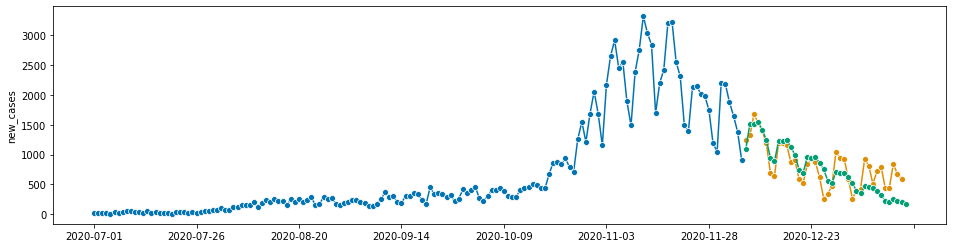

In [84]:
y_pred = y_trend_pred * y_season_pred
plot_series(y_train, y_test, y_pred)
print('sMAPE:', smape_loss(y_test, y_pred))

This method seems to work well for forecasting the new COVID-19 cases. During the first few days of the horizon. 

Finally, we'll try to predict the future progression of the virus, using this method.

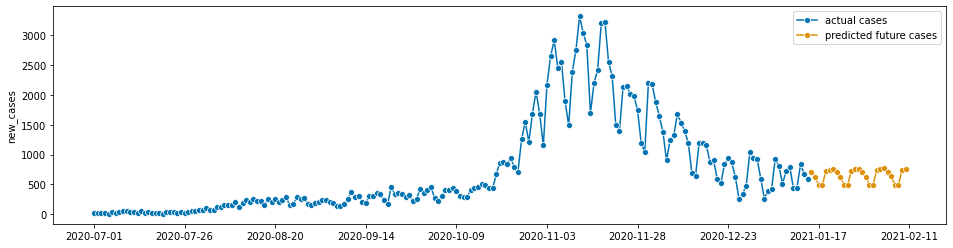

In [85]:
# Decompose the full timeseries
dec = seasonal_decompose(convert_to_dt(y.dropna()), model='multiplicative')
y_trend = dec.trend.dropna().to_period('D')
y_season = dec.seasonal.dropna().to_period('D')

# Define a new forecasting horizon 
# (the previous one used the dates from the test set)
fh = ForecastingHorizon(np.arange(30) + 1)

# Train trend and seasonal models
es_trend.fit(y_trend)
y_trend_pred = es_trend.predict(fh)

es_season.fit(y_season)
y_season_pred = es_season.predict(fh)

# Combine two preds for final prediction
y_pred = y_trend_pred * y_season_pred

# Plot the results
plot_series(y, y_pred, labels=['actual cases', 'predicted future cases']);